# Black-box Evasion Attacks on Network Intrusion Detection

This notebook demonstrates black-box evasion strategies against a trained supervised detection model.

Only labeled historical traffic is available (benign + attack), and all attacks are designed to be **blind** and **realistic**.

We implement **3 black-box attacks**, each progressively stronger:
1. Flag Suppression 
2. Feature Dropout 
3. Random Class Blending 


In [1]:
import os
import pandas as pd
import numpy as np
from joblib import load
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)

# Suppress warnings
warnings.simplefilter("ignore", category=FutureWarning)

# === Paths ===
model_path = '../../models/5_supervised_real_traffic_test/model.joblib'
benign_path = '../../real_data/benign'
attack_path = '../../real_data/attack'

# === Load model
model = load(model_path)

# === Helper: Load all labeled CSVs from a folder ===
def load_labeled_csvs(folder, label):
    dfs = []
    for fname in os.listdir(folder):
        if fname.endswith('.csv'):
            df = pd.read_csv(os.path.join(folder, fname))
            df['attack'] = label
            dfs.append(df)
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

# === Load benign and attack traffic
benign_df = load_labeled_csvs(benign_path, 0)
attack_df = load_labeled_csvs(attack_path, 1)

# === Combine and prepare data
df_all = pd.concat([benign_df, attack_df], ignore_index=True)
X = df_all.drop(columns=['attack'])
y = df_all['attack']

print(f"✅ Loaded {len(benign_df)} benign, {len(attack_df)} attack samples")
print("📊 Real Traffic Evaluation on Untouched Data:")
y_pred = model.predict(X)
print(classification_report(y, y_pred, target_names=["Benign", "Attack"]))

✅ Loaded 964995 benign, 1067088 attack samples
📊 Real Traffic Evaluation on Untouched Data:
              precision    recall  f1-score   support

      Benign       1.00      0.75      0.86    964995
      Attack       0.82      1.00      0.90   1067088

    accuracy                           0.88   2032083
   macro avg       0.91      0.88      0.88   2032083
weighted avg       0.90      0.88      0.88   2032083



In [2]:
def evaluate_attack(y_true, y_pred, y_scores, title=""):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_scores)

    attack_mask = (y_true == 1)
    evaded = np.sum((y_true == 1) & (y_pred == 0))
    total_attacks = np.sum(attack_mask)
    evasion_rate = evaded / total_attacks if total_attacks > 0 else 0

    print(f"Classification Report – {title}")
    print(classification_report(y_true, y_pred, target_names=["Benign", "Attack"]))
    print(f"Accuracy:         {acc:.4f}")
    print(f"Precision:        {prec:.4f}")
    print(f"Recall:           {rec:.4f}")
    print(f"F1-Score:         {f1:.4f}")
    print(f"ROC AUC:          {auc:.4f}")
    print(f"Evasion Rate:  {evasion_rate:.2%} ({evaded} of {total_attacks} attacks)")

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Attack'], yticklabels=['Benign', 'Attack'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix – {title}")
    plt.tight_layout()
    plt.show()


## Black-box Attack 1: Flag Suppression (Light)

This is a minimal, plausible black-box attack:
- The attacker has **no access** to model internals (weights, probabilities, thresholds).
- They assume that **TCP flag features** (e.g., FIN, RST, URG) contribute to attack detection.
- The attacker manually zeroes out these flags in attack samples to try to look more benign.

We apply this modification to `fin_flag_count`, `syn_flag_count`, `rst_flag_count`, `psh_flag_count`, `ack_flag_count`, and `urg_flag_count` in the attack samples — if present.



Suppressed flags in attack samples: ['fin flag count', 'syn flag count', 'rst flag count', 'psh flag count', 'ack flag count', 'urg flag count']
Classification Report – Black-box Attack 1 – Flag Suppression
              precision    recall  f1-score   support

      Benign       1.00      0.75      0.86    964995
      Attack       0.82      1.00      0.90   1067088

    accuracy                           0.88   2032083
   macro avg       0.91      0.88      0.88   2032083
weighted avg       0.90      0.88      0.88   2032083

Accuracy:         0.8820
Precision:        0.8165
Recall:           1.0000
F1-Score:         0.8990
ROC AUC:          0.9335
Evasion Rate:  0.00% (22 of 1067088 attacks)


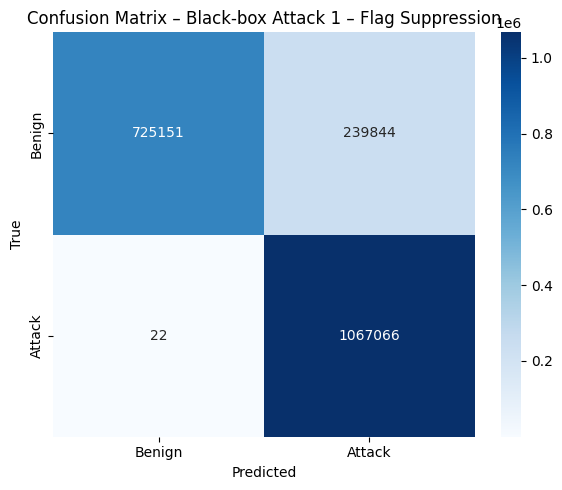

In [4]:
# Clone original data
X_adv1 = X.copy()
y_adv1 = y.copy()

# Identify attack rows
attack_indices = y_adv1[y_adv1 == 1].index

# Flags to suppress
flag_columns = [
    'fin flag count', 'syn flag count', 'rst flag count',
    'psh flag count', 'ack flag count', 'urg flag count'
]

# Suppress each flag in the attack samples
suppressed = []
for col in flag_columns:
    if col in X_adv1.columns:
        X_adv1.loc[attack_indices, col] = 0
        suppressed.append(col)

print(f"Suppressed flags in attack samples: {suppressed}")

# Run model
y_pred_adv1 = model.predict(X_adv1)
y_prob_adv1 = model.predict_proba(X_adv1)[:, 1]

# Evaluate with the helper
evaluate_attack(
    y_true=y_adv1,
    y_pred=y_pred_adv1,
    y_scores=y_prob_adv1,
    title="Black-box Attack 1 – Flag Suppression"
)


## Black-box Attack 2 – Controlled Blending at α = 0.10

In this refined black-box evasion attempt, we blend each attack flow with a benign flow at a ratio of **10% benign + 90% attack**:

1. **Sample** one benign flow for each attack sample (with replacement).
2. **Blend** feature vectors via  
   \[
     X_{\text{blend}} = 0.10 \times X_{\text{benign}} \;+\; 0.90 \times X_{\text{attack}}
   \]
3. **Label** all blended samples as “attack” (\(y=1\)) and combine them with the remaining real benign flows.
4. **Evaluate** using the `evaluate_attack` helper to report:
   - Classification report (precision, recall, F1, etc.)
   - Confusion matrix
   - ROC AUC
   - **Evasion rate** (percentage of blended attacks misclassified as benign)

By using a low blending ratio, we keep most of the original attack characteristics, making this a **realistic yet effective** evasion strategy.


Classification Report – Black-box Attack 2 – Full-Feature Blending (α=0.1)
              precision    recall  f1-score   support

      Benign       0.58      0.75      0.65    964995
      Attack       0.69      0.50      0.58   1067088

    accuracy                           0.62   2032083
   macro avg       0.63      0.63      0.62   2032083
weighted avg       0.64      0.62      0.62   2032083

Accuracy:         0.6215
Precision:        0.6916
Recall:           0.5040
F1-Score:         0.5831
ROC AUC:          0.7948
Evasion Rate:  49.60% (529236 of 1067088 attacks)


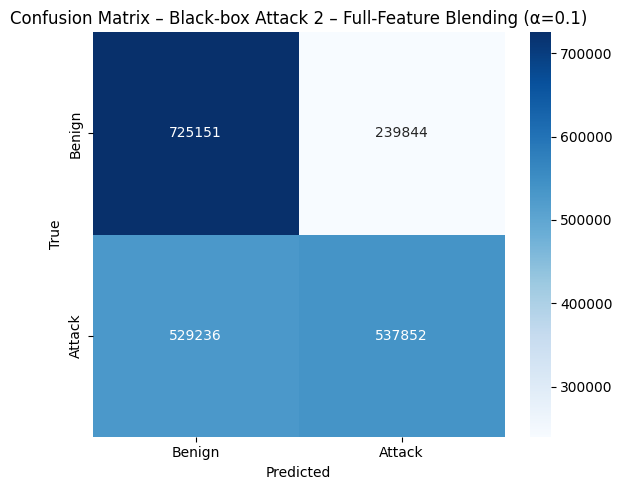

In [5]:
# 1. Prepare data
X_bb2 = X.copy()
y_bb2 = y.copy()
attack_idx = y_bb2[y_bb2 == 1].index
benign_idx = y_bb2[y_bb2 == 0].index

# 2. Sample equal pools
n_att = len(attack_idx)
benign_pool = X_bb2.loc[benign_idx].sample(n=n_att, replace=True, random_state=42).reset_index(drop=True)
attack_pool = X_bb2.loc[attack_idx].reset_index(drop=True)

# 3. Blend full vectors with α=0.10
alpha = 0.10
X_blend = alpha * benign_pool + (1 - alpha) * attack_pool

# 4. Build test set
X_test = pd.concat([
    X_bb2.loc[benign_idx],  # all benign
    X_blend                 # blended “attack” flows
], ignore_index=True)
y_test = pd.concat([
    y_bb2.loc[benign_idx],
    pd.Series([1] * n_att)
], ignore_index=True)

# 5. Predict & evaluate
y_pred2 = model.predict(X_test)
y_prob2 = model.predict_proba(X_test)[:, 1]
evaluate_attack(y_test, y_pred2, y_prob2,
                title=f"Black-box Attack 2 – Full-Feature Blending (α={alpha})")


## Black-box Attack 3 – High-Intensity Class Blending (α = 0.8)

This strong, fully black-box evasion method blends each attack flow with a benign flow at **80% benign + 20% attack**:

1. **Sample** one benign flow (with replacement) for each attack sample.
2. **Blend** feature vectors via  
   \[
     X_{\text{blend}} = 0.80 \times X_{\text{benign}} + 0.20 \times X_{\text{attack}}
   \]
3. **Label** all blended samples as “attack” (\(y=1\)) and combine them with the real benign flows.
4. **Evaluate** using the `evaluate_attack` helper to report:
   - Classification report (precision, recall, F1, ROC AUC)
   - Confusion matrix
   - **Evasion rate** (percentage of blended attacks misclassified as benign)



Classification Report – Black-box Attack 3 – Class Blending (α=0.80)
              precision    recall  f1-score   support

      Benign       0.47      0.75      0.58    964995
      Attack       0.53      0.25      0.34   1067088

    accuracy                           0.49   2032083
   macro avg       0.50      0.50      0.46   2032083
weighted avg       0.50      0.49      0.45   2032083

Accuracy:         0.4875
Precision:        0.5254
Recall:           0.2488
F1-Score:         0.3377
ROC AUC:          0.4940
Evasion Rate:  75.12% (801613 of 1067088 attacks)


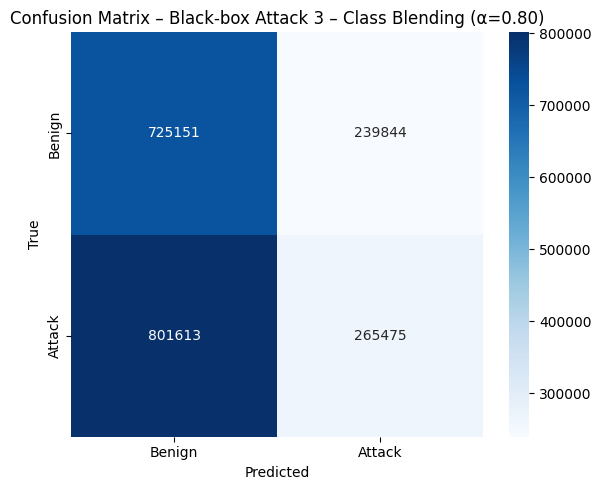

In [6]:
# 1. Prepare data
X_bb3 = X.copy()
y_bb3 = y.copy()
attack_idx = y_bb3[y_bb3 == 1].index
benign_idx = y_bb3[y_bb3 == 0].index
n_att = len(attack_idx)

# 2. Sample benign pool
benign_pool = X_bb3.loc[benign_idx].sample(n=n_att, replace=True, random_state=42).reset_index(drop=True)
attack_pool = X_bb3.loc[attack_idx].reset_index(drop=True)

# 3. Blend full feature vectors at α=0.8
alpha = 0.8
X_blend = alpha * benign_pool + (1 - alpha) * attack_pool

# 4. Build adversarial test set
X_test = pd.concat([
    X_bb3.loc[benign_idx],   # real benign
    X_blend                  # blended "attack" samples
], ignore_index=True)
y_test = pd.concat([
    y_bb3.loc[benign_idx],
    pd.Series([1] * n_att)
], ignore_index=True)

# 5. Predict and evaluate
y_pred3 = model.predict(X_test)
y_prob3 = model.predict_proba(X_test)[:, 1]
evaluate_attack(y_test, y_pred3, y_prob3,
                title=f"Black-box Attack 3 – Class Blending (α={alpha:.2f})")
